[View in Colaboratory](https://colab.research.google.com/github/Sarkin/nlp2018/blob/master/HW_DNN_6.ipynb)

In [0]:
!pip install -q http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl torchvision

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.cuda import FloatTensor, LongTensor

import numpy as np

np.random.seed(42)

# Свёрточные нейронные сети

Напомню, свертки - это то, с чего начался хайп нейронных сетей в районе 2012-ого.

Работают они примерно так:  
![Conv example](http://deeplearning.stanford.edu/wiki/images/6/6c/Convolution_schematic.gif)   
From [Feature extraction using convolution](http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution).

Формально - учатся наборы фильтров, каждый из которых скалярно умножается на элементы матрицы признаков. На картинке выше исходная матрица сворачивается с фильтром
$$
 \begin{pmatrix}
  1 & 0 & 1 \\
  0 & 1 & 0 \\
  1 & 0 & 1
 \end{pmatrix}
$$

Но нужно не забывать, что свертки обычно имеют ещё такую размерность, как число каналов. Например, картинки имеют обычно три канала: RGB.  
Наглядно демонстрируется как выглядят при этом фильтры [здесь](http://cs231n.github.io/convolutional-networks/#conv).

После сверток обычно следуют pooling-слои. Они помогают уменьшить размерность тензора, с которым приходится работать. Самым частым является max-pooling:  
![maxpooling](http://cs231n.github.io/assets/cnn/maxpool.jpeg =x300)  
From [CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/convolutional-networks/#pool)

## Character-Level Convolutions
Мы говорим про свертки для работы с текстами. Совсем не очевидно, что они вообще должны помочь в работе с текстами. То есть в изображениях они отлавливают некоторые локальные особенности, такие как:
![weights](https://i.stack.imgur.com/Hl2H6.png)

Для текстов свертки работают как n-граммные детекторы (примерно). Посмотрите на пример символьной сверточной сети:

![text-convs](https://image.ibb.co/bC3Xun/2018_03_27_01_24_39.png =x500)  
From [Character-Aware Neural Language Models](https://arxiv.org/abs/1508.06615)

*Сколько учится фильтров на данном примере?*

На картинке показано, как из слова извлекаются 2, 3 и 4-граммы. Например, желтые - это триграммы. Желтый фильтр прикладывают ко всем триграммам в слове, а потом с помощью global max-pooling извлекают наиболее сильный сигнал.

Что это значит, если конкретнее?

Каждый символ отображается с помощью эмбеддингов в некоторый вектор. А их последовательности - в конкатенации эмбеддингов.  
Например, "abs" $\to [v_a; v_b; v_s] \in \mathbb{R}^{3 d}$, где $d$ - размерность эмбеддинга. Желтый фильтр $f_k$ имеет такую же размерность $3d$.  
Его прикладывание - это скалярное произведение $\left([v_a; v_b; v_s] \odot f_k \right) \in \mathbb R$ (один из желтых квадратиков в feature map для данного фильтра).

Max-pooling выбирает $max_i \left( [v_{i-1}; v_{i}; v_{i+1}] \odot f_k \right)$, где $i$ пробегается по всем индексам слова от 1 до $|w| - 1$ (либо по большему диапазону, если есть padding'и).   
Этот максимум соответствует той триграмме, которая наиболее близка к фильтру по косинусному расстоянию.

В результате в векторе после max-pooling'а закодирована информация о том, какие из n-грамм встретились в слове: если встретилась близкая к нашему $f_k$ триграмма, то в $k$-той позиции вектора будет стоять большое значение, иначе - маленькое.

А учим мы как раз фильтры. То есть сеть должна научиться определять, какие из n-грамм значимы, а какие - нет.

### Классификация слов

Будем учиться предсказывать, является ли слово фамилией.

Скачаем данные.

In [0]:
!wget -qq -O surnames.txt https://share.abbyy.com/index.php/s/mt5r9vEZo70sfIS/download

In [0]:
from sklearn.model_selection import train_test_split

with open('surnames.txt') as f:
    lines = f.readlines()
    data = [line.strip().split('\t')[0] for line in lines]
    labels = [int(line.strip().split('\t')[1]) for line in lines]
    del lines
    
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

Данные, как видно, грязноваты:

In [4]:
list(zip(X_train, y_train))[:10]

[('аминов', 1),
 ('переточек', 0),
 ('Оманом', 0),
 ('Говядину', 0),
 ('дарвинистам', 0),
 ('зёрнышком', 0),
 ('Ролинсе', 1),
 ('гостиница', 0),
 ('Суфизм', 0),
 ('ядовитостью', 0)]

Начнем с бейзлайна - логистической регрессии на n-граммах символов.

**Задание** Сделать классификацию с LogisticRegression моделью. Посчитать F1-меру.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = CountVectorizer(analyzer='char', ngram_range=(3,3), lowercase=False)

X_train_sparse = vectorizer.fit_transform(X_train)

In [0]:
X_test_sparse = vectorizer.transform(X_test)

In [7]:
print(X_train_sparse.shape)

(67943, 17425)


In [8]:
lr = LogisticRegression()
lr.fit(X_train_sparse, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, precision_score, recall_score

y_pred = lr.predict(X_test_sparse)

print("Accuracy: {} F1 score {}".format(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)))

Accuracy: 0.9232631107126849 F1 score 0.5178370259106271


Как всегда, сконвертируем их для начала:

In [10]:
from collections import Counter 
    
def find_max_len(counter, threshold):
    sum_count = sum(counter.values())
    cum_count = 0
    for i in range(max(counter)):
        cum_count += counter[i]
        if cum_count > sum_count * threshold:
            return i
    return max(counter)

word_len_counter = Counter()
for word in X_train:
    word_len_counter[len(word)] += 1
    
threshold = 0.99
MAX_WORD_LEN = find_max_len(word_len_counter, threshold)

print('Max word len for {:.0%} of words is {}'.format(threshold, MAX_WORD_LEN))

Max word len for 99% of words is 16


In [11]:
chars = set()
for word in X_train:
    chars.update(word)

char_index = {c : i + 1 for i, c in enumerate(chars)}
char_index[''] = 0

def get_char_index(char, char_index):
    return char_index[char] if char in char_index else len(char_index)
  
print(char_index)

{'п': 1, 'ч': 2, '-': 3, '/': 4, 'М': 5, '«': 6, 'ф': 7, ' ': 8, 'у': 9, '2': 10, '’': 11, 'Д': 12, 'Ы': 13, '.': 14, '7': 15, 'м': 16, 'Щ': 17, 'Б': 18, 'Ь': 19, 'т': 20, 'к': 21, 'щ': 22, 'в': 23, 'о': 24, 'а': 25, 'ы': 26, 'г': 27, 'В': 28, 'Е': 29, 'х': 30, 'е': 31, '3': 32, 'ъ': 33, 'Л': 34, 'д': 35, 'Ё': 36, "'": 37, 'ё': 38, 'н': 39, 'ó': 40, 'Р': 41, 'ю': 42, 'У': 43, 'й': 44, 'Ж': 45, 'К': 46, 'Х': 47, 'ж': 48, 'Я': 49, 'Т': 50, 'А': 51, 'Ш': 52, 'з': 53, 'Ъ': 54, 'б': 55, 'И': 56, 'З': 57, 'П': 58, 'ц': 59, 'ѐ': 60, 'Ф': 61, 'и': 62, 'р': 63, 'Ч': 64, 'Г': 65, 'Ю': 66, 'Ó': 67, '»': 68, '·': 69, 'я': 70, 'Н': 71, 'л': 72, 'ь': 73, 'Ц': 74, 'с': 75, 'ш': 76, 'Й': 77, 'э': 78, 'Э': 79, 'О': 80, 'С': 81, '': 0}


In [0]:
def convert_data(data, max_word_len, char_index):
    X = np.zeros((len(data), max_word_len))
    for i, word in enumerate(data):
        word = word[-max_word_len:]
        X[i, :len(word)] = [get_char_index(symb, char_index) for symb in word]
        
    return LongTensor(X)
  
X_train = convert_data(X_train, MAX_WORD_LEN, char_index)
X_test = convert_data(X_test, MAX_WORD_LEN, char_index)

y_train = FloatTensor(y_train)
y_test = FloatTensor(y_test)

In [0]:
def iterate_batches(dataset, batch_size):
    X, y = dataset
    num_samples = X.shape[0]

    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        
        batch_idx = indices[start:end]
        
        yield Variable(X[batch_idx, ]), Variable(y[batch_idx, ])

Теперь построим свёрточную модель.

Типичным является блок:
```python
nn.Conv*d(in_channels=N, out_channels=M, kernel_size=K1, padding=0)
F.relu
nn.MaxPool*d(kernel_size=K2)
```

Пусть она будет строить триграммы - то есть применять фильтры на 3 символа.

Какие нам нужны размерности?

In [0]:
class ConvClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, filters_count):
        super().__init__()
        
        self.char_emb = nn.Embedding(vocab_size, emb_dim)
        self.cnn = nn.Conv2d(in_channels=1, out_channels=filters_count, kernel_size=(3, emb_dim))
        self.pool = nn.MaxPool1d(MAX_WORD_LEN - 2)
        self.out = nn.Linear(filters_count, 1)
        
    def forward(self, inp):
        '''
        inp.size() = (batch_size, max_word_len)
        out.size() = (batch_size,)
        '''
        emb = self.char_emb(inp).unsqueeze(1)
        cnn_out = F.relu(self.cnn(emb)).squeeze()
        pool_out = self.pool(cnn_out).squeeze()
        return self.out(pool_out).squeeze()

В данной задаче несбалансированные классы, поэтому хочется мерять $F_1$-меру.

Напомню:

![precision-recall](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png =x600)  
From [Precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall).

$$\text{precision} = \frac{tp}{tp + fp}.$$
$$\text{recall} = \frac{tp}{tp + fn}.$$
$$\text{F}_1 = 2\frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}.$$

In [84]:
model = ConvClassifier(len(char_index) + 1, 24, 128).cuda()

X_batch, y_batch = next(iterate_batches((X_train, y_train), 32))

#<calculate precision, recall and F1-score>
logit = model(X_batch)
preds = (logit.sigmoid() > 0.5)
precision_recall_fscore_support(y_batch.data, preds.data)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([0.875, 0.   ]),
 array([1., 0.]),
 array([0.93333333, 0.        ]),
 array([28,  4]))

In [0]:
import math
import time

def do_epoch(model, criterion, data, batch_size, optimizer=None):
    epoch_loss = 0
    epoch_tp = 0
    epoch_tpfn = 0
    epoch_tpfp = 0
    
    model.train(not optimizer is None)
    
    batchs_count = math.ceil(data[0].shape[0] / batch_size)
    
    for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
        logits = model(X_batch)
        
        loss = criterion(logits, y_batch)
        epoch_loss += loss.data[0]
        
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        preds = (logits.sigmoid() > 0.5).long()
        epoch_tp += (preds * y_batch.long()).sum()
        epoch_tpfn += (y_batch.long() * (1 - preds)).sum()
        epoch_tpfp += ((1 - y_batch.long()) * preds).sum()
    
        
        precision = precision_score(y_batch.data, preds.data)
        recall = recall_score(y_batch.data, preds.data)
        f1 = f1_score(y_batch.data, preds.data)
      
        print('\r[{} / {}]: Loss = {:.5f}, Precision = {:.2%}, Recall = {:.2%}, F1 = {:.2%}'.format(
              i, batchs_count, loss.data[0], precision, recall, f1), end='')
        
    
    epoch_tp = epoch_tp.data[0]
    epoch_tpfn = epoch_tpfn.data[0]
    epoch_tpfp = epoch_tpfp.data[0]
    precision = epoch_tp / (epoch_tp + epoch_tpfp)
    recall = epoch_tp / (epoch_tp + epoch_tpfn)
    f1 = 2 * precision *  recall / (precision + recall)
    
    return epoch_loss / batchs_count, recall, precision, f1

def fit(model, criterion, optimizer, train_data, epochs_count=1, 
        batch_size=32, val_data=None, val_batch_size=None):
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        start_time = time.time()
        train_loss, train_recall, train_precision, train_f1 = \
            do_epoch(model, criterion, train_data, batch_size, optimizer)
        
        output_info = '\rEpoch {} / {}, Epoch Time = {:.2f}s: Train Loss = {:.5f}, Precision = {:.2%}, Recall = {:.2%}, F1 = {:.2%}'
        if not val_data is None:
            val_loss, val_recall, val_precision, val_f1 = \
                do_epoch(model, criterion, val_data, val_batch_size, None)
            
            epoch_time = time.time() - start_time
            output_info += ', Val Loss = {:.5f}, Precision = {:.2%}, Recall = {:.2%}, F1 = {:.2%}'
            print(output_info.format(epoch+1, epochs_count, epoch_time, 
                                     train_loss, train_recall, train_precision, train_f1,
                                     val_loss, val_recall, val_precision, val_f1))
        else:
            epoch_time = time.time() - start_time
            print(output_info.format(epoch+1, epochs_count, epoch_time, train_loss))

In [92]:
model = ConvClassifier(len(char_index) + 1, 24, 256).cuda()

criterion = nn.BCEWithLogitsLoss().cuda()

optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad])

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=100, 
    batch_size=512, val_data=(X_test, y_test), val_batch_size=1024)

[5 / 133]: Loss = 0.32265, Precision = 0.00%, Recall = 0.00%, F1 = 0.00%

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 1 / 100, Epoch Time = 4.77s: Train Loss = 0.29604, Precision = 1.37%, Recall = 62.42%, F1 = 2.69%, Val Loss = 0.26623, Precision = 5.03%, Recall = 66.92%, F1 = 9.36%
Epoch 2 / 100, Epoch Time = 4.66s: Train Loss = 0.24874, Precision = 16.23%, Recall = 68.18%, F1 = 26.22%, Val Loss = 0.24182, Precision = 28.78%, Recall = 62.59%, F1 = 39.43%
Epoch 3 / 100, Epoch Time = 4.73s: Train Loss = 0.22903, Precision = 28.81%, Recall = 69.87%, F1 = 40.80%, Val Loss = 0.22896, Precision = 29.07%, Recall = 68.53%, F1 = 40.82%
Epoch 4 / 100, Epoch Time = 4.73s: Train Loss = 0.21786, Precision = 34.37%, Recall = 71.46%, F1 = 46.42%, Val Loss = 0.22240, Precision = 36.12%, Recall = 68.40%, F1 = 47.28%
Epoch 5 / 100, Epoch Time = 4.70s: Train Loss = 0.20974, Precision = 37.76%, Recall = 72.94%, F1 = 49.76%, Val Loss = 0.22013, Precision = 39.64%, Recall = 67.20%, F1 = 49.87%
Epoch 6 / 100, Epoch Time = 4.68s: Train Loss = 0.20344, Precision = 40.43%, Recall = 73.60%, F1 = 52.19%, Val Loss = 0.2148

Epoch 8 / 100, Epoch Time = 4.71s: Train Loss = 0.19328, Precision = 44.78%, Recall = 75.81%, F1 = 56.31%, Val Loss = 0.21127, Precision = 40.58%, Recall = 69.30%, F1 = 51.19%
Epoch 9 / 100, Epoch Time = 4.69s: Train Loss = 0.18860, Precision = 46.56%, Recall = 76.71%, F1 = 57.95%, Val Loss = 0.21157, Precision = 35.95%, Recall = 71.60%, F1 = 47.87%
Epoch 10 / 100, Epoch Time = 4.65s: Train Loss = 0.18439, Precision = 48.00%, Recall = 77.55%, F1 = 59.30%, Val Loss = 0.21071, Precision = 49.04%, Recall = 66.87%, F1 = 56.59%
Epoch 11 / 100, Epoch Time = 4.67s: Train Loss = 0.18075, Precision = 49.56%, Recall = 78.24%, F1 = 60.68%, Val Loss = 0.20768, Precision = 43.93%, Recall = 69.96%, F1 = 53.97%
Epoch 12 / 100, Epoch Time = 4.61s: Train Loss = 0.17659, Precision = 51.53%, Recall = 78.97%, F1 = 62.37%, Val Loss = 0.20759, Precision = 40.95%, Recall = 72.05%, F1 = 52.22%
Epoch 13 / 100, Epoch Time = 4.75s: Train Loss = 0.17378, Precision = 51.52%, Recall = 79.18%, F1 = 62.42%, Val Loss 

Epoch 15 / 100, Epoch Time = 4.65s: Train Loss = 0.16722, Precision = 53.65%, Recall = 80.39%, F1 = 64.35%, Val Loss = 0.20705, Precision = 50.93%, Recall = 67.58%, F1 = 58.08%
Epoch 16 / 100, Epoch Time = 4.72s: Train Loss = 0.16343, Precision = 55.26%, Recall = 80.99%, F1 = 65.70%, Val Loss = 0.20634, Precision = 46.04%, Recall = 70.69%, F1 = 55.76%
Epoch 17 / 100, Epoch Time = 4.65s: Train Loss = 0.16115, Precision = 56.17%, Recall = 81.09%, F1 = 66.37%, Val Loss = 0.20559, Precision = 49.64%, Recall = 69.23%, F1 = 57.82%
Epoch 18 / 100, Epoch Time = 4.62s: Train Loss = 0.15920, Precision = 56.13%, Recall = 81.11%, F1 = 66.35%, Val Loss = 0.20717, Precision = 48.76%, Recall = 70.00%, F1 = 57.48%
Epoch 19 / 100, Epoch Time = 4.67s: Train Loss = 0.15495, Precision = 58.37%, Recall = 82.19%, F1 = 68.26%, Val Loss = 0.20486, Precision = 47.90%, Recall = 70.93%, F1 = 57.18%
Epoch 20 / 100, Epoch Time = 4.74s: Train Loss = 0.15313, Precision = 58.83%, Recall = 81.98%, F1 = 68.50%, Val Los

Epoch 22 / 100, Epoch Time = 4.68s: Train Loss = 0.14809, Precision = 60.08%, Recall = 82.85%, F1 = 69.65%, Val Loss = 0.20657, Precision = 50.21%, Recall = 70.65%, F1 = 58.70%
Epoch 23 / 100, Epoch Time = 4.67s: Train Loss = 0.14538, Precision = 60.48%, Recall = 83.86%, F1 = 70.28%, Val Loss = 0.20804, Precision = 54.33%, Recall = 67.17%, F1 = 60.07%
Epoch 24 / 100, Epoch Time = 4.68s: Train Loss = 0.14297, Precision = 61.73%, Recall = 83.62%, F1 = 71.03%, Val Loss = 0.20980, Precision = 43.78%, Recall = 74.95%, F1 = 55.28%
Epoch 25 / 100, Epoch Time = 4.72s: Train Loss = 0.14035, Precision = 62.08%, Recall = 83.97%, F1 = 71.39%, Val Loss = 0.20840, Precision = 47.36%, Recall = 73.32%, F1 = 57.54%
Epoch 26 / 100, Epoch Time = 4.68s: Train Loss = 0.13792, Precision = 62.99%, Recall = 84.29%, F1 = 72.10%, Val Loss = 0.20782, Precision = 46.56%, Recall = 74.49%, F1 = 57.30%
Epoch 27 / 100, Epoch Time = 4.72s: Train Loss = 0.13600, Precision = 63.58%, Recall = 84.38%, F1 = 72.52%, Val Los

Epoch 29 / 100, Epoch Time = 4.70s: Train Loss = 0.13241, Precision = 64.91%, Recall = 85.66%, F1 = 73.85%, Val Loss = 0.20996, Precision = 54.53%, Recall = 67.28%, F1 = 60.24%
Epoch 30 / 100, Epoch Time = 4.77s: Train Loss = 0.12946, Precision = 65.70%, Recall = 85.37%, F1 = 74.25%, Val Loss = 0.20962, Precision = 48.24%, Recall = 72.54%, F1 = 57.95%
Epoch 31 / 100, Epoch Time = 4.67s: Train Loss = 0.12758, Precision = 65.99%, Recall = 85.65%, F1 = 74.55%, Val Loss = 0.21389, Precision = 45.10%, Recall = 74.26%, F1 = 56.12%
Epoch 32 / 100, Epoch Time = 4.71s: Train Loss = 0.12555, Precision = 66.98%, Recall = 85.58%, F1 = 75.15%, Val Loss = 0.21267, Precision = 53.39%, Recall = 66.31%, F1 = 59.15%
Epoch 33 / 100, Epoch Time = 4.66s: Train Loss = 0.12537, Precision = 66.97%, Recall = 85.85%, F1 = 75.24%, Val Loss = 0.21156, Precision = 48.01%, Recall = 72.51%, F1 = 57.77%
Epoch 34 / 100, Epoch Time = 4.73s: Train Loss = 0.12237, Precision = 67.19%, Recall = 86.75%, F1 = 75.73%, Val Los

Epoch 36 / 100, Epoch Time = 4.78s: Train Loss = 0.12157, Precision = 68.23%, Recall = 85.89%, F1 = 76.05%, Val Loss = 0.21698, Precision = 56.39%, Recall = 63.48%, F1 = 59.72%
Epoch 37 / 100, Epoch Time = 4.77s: Train Loss = 0.11738, Precision = 69.42%, Recall = 86.61%, F1 = 77.07%, Val Loss = 0.21422, Precision = 52.30%, Recall = 68.28%, F1 = 59.23%
Epoch 38 / 100, Epoch Time = 4.72s: Train Loss = 0.11632, Precision = 69.35%, Recall = 87.41%, F1 = 77.34%, Val Loss = 0.21600, Precision = 49.84%, Recall = 69.57%, F1 = 58.08%
Epoch 39 / 100, Epoch Time = 4.75s: Train Loss = 0.11349, Precision = 70.16%, Recall = 87.85%, F1 = 78.02%, Val Loss = 0.21800, Precision = 54.82%, Recall = 65.75%, F1 = 59.79%
Epoch 40 / 100, Epoch Time = 4.83s: Train Loss = 0.11206, Precision = 70.57%, Recall = 87.54%, F1 = 78.14%, Val Loss = 0.22172, Precision = 57.79%, Recall = 62.31%, F1 = 59.96%
Epoch 41 / 100, Epoch Time = 4.71s: Train Loss = 0.11012, Precision = 71.72%, Recall = 88.06%, F1 = 79.06%, Val Los

Epoch 43 / 100, Epoch Time = 4.69s: Train Loss = 0.10725, Precision = 72.07%, Recall = 88.39%, F1 = 79.40%, Val Loss = 0.22391, Precision = 48.27%, Recall = 69.53%, F1 = 56.98%
Epoch 44 / 100, Epoch Time = 4.73s: Train Loss = 0.10636, Precision = 72.62%, Recall = 88.46%, F1 = 79.76%, Val Loss = 0.22871, Precision = 58.93%, Recall = 59.75%, F1 = 59.34%
Epoch 45 / 100, Epoch Time = 4.73s: Train Loss = 0.10504, Precision = 72.78%, Recall = 88.17%, F1 = 79.74%, Val Loss = 0.22368, Precision = 51.61%, Recall = 68.07%, F1 = 58.71%
Epoch 46 / 100, Epoch Time = 4.73s: Train Loss = 0.10390, Precision = 73.12%, Recall = 88.72%, F1 = 80.17%, Val Loss = 0.22494, Precision = 49.61%, Recall = 69.33%, F1 = 57.84%
Epoch 47 / 100, Epoch Time = 4.72s: Train Loss = 0.10321, Precision = 73.20%, Recall = 88.23%, F1 = 80.02%, Val Loss = 0.22693, Precision = 57.73%, Recall = 62.19%, F1 = 59.88%
Epoch 48 / 100, Epoch Time = 4.76s: Train Loss = 0.10162, Precision = 73.71%, Recall = 88.60%, F1 = 80.47%, Val Los

Epoch 50 / 100, Epoch Time = 4.85s: Train Loss = 0.09824, Precision = 75.04%, Recall = 89.28%, F1 = 81.54%, Val Loss = 0.23224, Precision = 47.21%, Recall = 71.33%, F1 = 56.82%
Epoch 51 / 100, Epoch Time = 4.73s: Train Loss = 0.09815, Precision = 74.70%, Recall = 89.06%, F1 = 81.25%, Val Loss = 0.22951, Precision = 51.24%, Recall = 67.28%, F1 = 58.18%
Epoch 52 / 100, Epoch Time = 4.72s: Train Loss = 0.09608, Precision = 75.56%, Recall = 89.60%, F1 = 81.98%, Val Loss = 0.23088, Precision = 51.61%, Recall = 67.69%, F1 = 58.57%
Epoch 53 / 100, Epoch Time = 4.72s: Train Loss = 0.09489, Precision = 76.03%, Recall = 89.72%, F1 = 82.31%, Val Loss = 0.23379, Precision = 52.13%, Recall = 65.80%, F1 = 58.17%
Epoch 54 / 100, Epoch Time = 4.74s: Train Loss = 0.09281, Precision = 76.27%, Recall = 89.64%, F1 = 82.42%, Val Loss = 0.23329, Precision = 49.99%, Recall = 68.37%, F1 = 57.75%
Epoch 55 / 100, Epoch Time = 4.77s: Train Loss = 0.09264, Precision = 76.22%, Recall = 89.83%, F1 = 82.46%, Val Los

Epoch 57 / 100, Epoch Time = 4.76s: Train Loss = 0.09030, Precision = 77.50%, Recall = 90.32%, F1 = 83.42%, Val Loss = 0.24209, Precision = 47.90%, Recall = 68.83%, F1 = 56.49%
Epoch 58 / 100, Epoch Time = 4.75s: Train Loss = 0.08890, Precision = 77.62%, Recall = 90.19%, F1 = 83.43%, Val Loss = 0.23813, Precision = 52.24%, Recall = 66.30%, F1 = 58.44%
Epoch 59 / 100, Epoch Time = 4.72s: Train Loss = 0.08923, Precision = 76.94%, Recall = 89.89%, F1 = 82.91%, Val Loss = 0.24288, Precision = 56.82%, Recall = 60.63%, F1 = 58.66%
Epoch 60 / 100, Epoch Time = 4.73s: Train Loss = 0.08844, Precision = 77.84%, Recall = 90.21%, F1 = 83.57%, Val Loss = 0.23916, Precision = 52.64%, Recall = 65.60%, F1 = 58.41%
Epoch 61 / 100, Epoch Time = 4.69s: Train Loss = 0.08674, Precision = 78.12%, Recall = 90.33%, F1 = 83.78%, Val Loss = 0.24087, Precision = 53.22%, Recall = 65.43%, F1 = 58.69%
Epoch 62 / 100, Epoch Time = 4.73s: Train Loss = 0.08515, Precision = 78.75%, Recall = 90.65%, F1 = 84.28%, Val Los

Epoch 64 / 100, Epoch Time = 4.77s: Train Loss = 0.08392, Precision = 78.75%, Recall = 90.66%, F1 = 84.29%, Val Loss = 0.24975, Precision = 48.16%, Recall = 67.62%, F1 = 56.25%
Epoch 65 / 100, Epoch Time = 4.74s: Train Loss = 0.08238, Precision = 79.20%, Recall = 91.00%, F1 = 84.69%, Val Loss = 0.24773, Precision = 53.93%, Recall = 63.75%, F1 = 58.43%
Epoch 66 / 100, Epoch Time = 4.82s: Train Loss = 0.08130, Precision = 79.91%, Recall = 91.35%, F1 = 85.25%, Val Loss = 0.24926, Precision = 55.04%, Recall = 62.11%, F1 = 58.36%
Epoch 67 / 100, Epoch Time = 4.77s: Train Loss = 0.07948, Precision = 80.47%, Recall = 91.38%, F1 = 85.58%, Val Loss = 0.25138, Precision = 50.99%, Recall = 65.54%, F1 = 57.35%
Epoch 68 / 100, Epoch Time = 4.74s: Train Loss = 0.08045, Precision = 80.36%, Recall = 91.14%, F1 = 85.41%, Val Loss = 0.25462, Precision = 56.39%, Recall = 59.73%, F1 = 58.01%
Epoch 69 / 100, Epoch Time = 4.77s: Train Loss = 0.07997, Precision = 80.40%, Recall = 90.78%, F1 = 85.28%, Val Los

Epoch 71 / 100, Epoch Time = 4.68s: Train Loss = 0.07639, Precision = 81.24%, Recall = 91.37%, F1 = 86.01%, Val Loss = 0.25898, Precision = 49.59%, Recall = 66.02%, F1 = 56.63%
Epoch 72 / 100, Epoch Time = 4.70s: Train Loss = 0.07660, Precision = 81.96%, Recall = 91.64%, F1 = 86.53%, Val Loss = 0.25751, Precision = 51.47%, Recall = 64.64%, F1 = 57.31%
Epoch 73 / 100, Epoch Time = 4.77s: Train Loss = 0.07472, Precision = 81.58%, Recall = 91.79%, F1 = 86.38%, Val Loss = 0.26410, Precision = 59.27%, Recall = 57.53%, F1 = 58.39%
Epoch 74 / 100, Epoch Time = 4.76s: Train Loss = 0.07401, Precision = 82.21%, Recall = 91.77%, F1 = 86.73%, Val Loss = 0.26076, Precision = 51.73%, Recall = 65.87%, F1 = 57.95%
Epoch 75 / 100, Epoch Time = 4.70s: Train Loss = 0.07403, Precision = 81.90%, Recall = 91.95%, F1 = 86.64%, Val Loss = 0.26054, Precision = 52.50%, Recall = 63.52%, F1 = 57.49%
Epoch 76 / 100, Epoch Time = 4.66s: Train Loss = 0.07176, Precision = 83.08%, Recall = 92.05%, F1 = 87.34%, Val Los

Epoch 78 / 100, Epoch Time = 4.69s: Train Loss = 0.07076, Precision = 82.83%, Recall = 92.12%, F1 = 87.23%, Val Loss = 0.26514, Precision = 53.90%, Recall = 61.59%, F1 = 57.49%
Epoch 79 / 100, Epoch Time = 4.75s: Train Loss = 0.07019, Precision = 83.16%, Recall = 91.90%, F1 = 87.32%, Val Loss = 0.26649, Precision = 52.27%, Recall = 63.22%, F1 = 57.23%
Epoch 80 / 100, Epoch Time = 4.73s: Train Loss = 0.06967, Precision = 83.47%, Recall = 92.43%, F1 = 87.72%, Val Loss = 0.26906, Precision = 53.50%, Recall = 61.30%, F1 = 57.13%
Epoch 81 / 100, Epoch Time = 4.70s: Train Loss = 0.06889, Precision = 83.88%, Recall = 92.41%, F1 = 87.94%, Val Loss = 0.27587, Precision = 48.50%, Recall = 66.78%, F1 = 56.19%
Epoch 82 / 100, Epoch Time = 4.75s: Train Loss = 0.06841, Precision = 83.63%, Recall = 92.26%, F1 = 87.73%, Val Loss = 0.27299, Precision = 49.67%, Recall = 66.31%, F1 = 56.80%
Epoch 83 / 100, Epoch Time = 4.73s: Train Loss = 0.06817, Precision = 84.19%, Recall = 91.98%, F1 = 87.91%, Val Los

Epoch 85 / 100, Epoch Time = 4.78s: Train Loss = 0.06693, Precision = 84.26%, Recall = 92.50%, F1 = 88.18%, Val Loss = 0.27589, Precision = 55.04%, Recall = 61.67%, F1 = 58.17%
Epoch 86 / 100, Epoch Time = 4.82s: Train Loss = 0.06544, Precision = 84.90%, Recall = 92.42%, F1 = 88.50%, Val Loss = 0.28140, Precision = 55.22%, Recall = 59.35%, F1 = 57.21%
Epoch 87 / 100, Epoch Time = 4.71s: Train Loss = 0.06389, Precision = 85.35%, Recall = 93.11%, F1 = 89.06%, Val Loss = 0.27817, Precision = 54.19%, Recall = 62.16%, F1 = 57.90%
Epoch 88 / 100, Epoch Time = 4.71s: Train Loss = 0.06415, Precision = 85.03%, Recall = 92.98%, F1 = 88.83%, Val Loss = 0.29254, Precision = 59.56%, Recall = 53.99%, F1 = 56.64%
Epoch 89 / 100, Epoch Time = 4.80s: Train Loss = 0.06465, Precision = 84.51%, Recall = 92.77%, F1 = 88.45%, Val Loss = 0.28228, Precision = 52.96%, Recall = 62.62%, F1 = 57.39%
Epoch 90 / 100, Epoch Time = 4.73s: Train Loss = 0.06283, Precision = 85.26%, Recall = 92.92%, F1 = 88.93%, Val Los

Epoch 92 / 100, Epoch Time = 4.72s: Train Loss = 0.06099, Precision = 86.20%, Recall = 93.37%, F1 = 89.64%, Val Loss = 0.29575, Precision = 59.85%, Recall = 54.72%, F1 = 57.17%
Epoch 93 / 100, Epoch Time = 4.73s: Train Loss = 0.06030, Precision = 86.19%, Recall = 93.14%, F1 = 89.53%, Val Loss = 0.28754, Precision = 54.33%, Recall = 61.30%, F1 = 57.61%
Epoch 94 / 100, Epoch Time = 4.76s: Train Loss = 0.06019, Precision = 86.22%, Recall = 93.26%, F1 = 89.60%, Val Loss = 0.28913, Precision = 50.56%, Recall = 65.16%, F1 = 56.94%
Epoch 95 / 100, Epoch Time = 4.73s: Train Loss = 0.05935, Precision = 86.15%, Recall = 93.27%, F1 = 89.57%, Val Loss = 0.29080, Precision = 57.10%, Recall = 57.90%, F1 = 57.50%
Epoch 96 / 100, Epoch Time = 4.76s: Train Loss = 0.05951, Precision = 86.26%, Recall = 93.18%, F1 = 89.58%, Val Loss = 0.29248, Precision = 53.76%, Recall = 61.47%, F1 = 57.36%
Epoch 97 / 100, Epoch Time = 4.79s: Train Loss = 0.05819, Precision = 86.65%, Recall = 93.36%, F1 = 89.88%, Val Los

Epoch 99 / 100, Epoch Time = 4.74s: Train Loss = 0.05752, Precision = 87.00%, Recall = 93.51%, F1 = 90.14%, Val Loss = 0.29808, Precision = 52.33%, Recall = 61.03%, F1 = 56.35%
Epoch 100 / 100, Epoch Time = 4.70s: Train Loss = 0.05664, Precision = 87.16%, Recall = 93.45%, F1 = 90.19%, Val Loss = 0.29714, Precision = 53.33%, Recall = 61.42%, F1 = 57.09%


**Задание** Различают Narrow и Wide свёртки - по сути, добавляется ли нулевой паддинг или нет. Для текстов эта разница выглядит так:  
![narrow_vs_wide](https://image.ibb.co/eqGZaS/2018_03_28_11_23_17.png)
From Neural Network Methods in Natural Language Processing.  
Слева - паддинг отсутствует, справа - есть. Попробуйте добавить паддинг и посмотреть, что получится. Потенциально он поможет выучить хорошие префиксы слова.

--- 

**Задание** Сравните качество и скорость работы с character-level LSTM (типа того, что был на третьем занятии).

In [0]:
class PaddingConvClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, filters_count):
        super().__init__()
        
        self.char_emb = nn.Embedding(vocab_size, emb_dim)
        self.cnn = nn.Conv2d(in_channels=1, out_channels=filters_count, kernel_size=(3, emb_dim), padding=(1, 0))
        self.pool = nn.MaxPool1d(MAX_WORD_LEN)
        self.out = nn.Linear(filters_count, 1)
        
    def forward(self, inp):
        '''
        inp.size() = (batch_size, max_word_len)
        out.size() = (batch_size,)
        '''
        emb = self.char_emb(inp).unsqueeze(1)
        cnn_out = F.relu(self.cnn(emb)).squeeze()
        pool_out = self.pool(cnn_out).squeeze()
        return self.out(pool_out).squeeze()

In [110]:
model = PaddingConvClassifier(len(char_index) + 1, 24, 256).cuda()

criterion = nn.BCEWithLogitsLoss().cuda()

optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad])

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=100, 
    batch_size=512, val_data=(X_test, y_test), val_batch_size=1024)

[7 / 133]: Loss = 0.35937, Precision = 0.00%, Recall = 0.00%, F1 = 0.00%

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 1 / 100, Epoch Time = 4.72s: Train Loss = 0.31383, Precision = 0.42%, Recall = 10.17%, F1 = 0.81%, Val Loss = 0.27433, Precision = 1.57%, Recall = 64.71%, F1 = 3.07%
Epoch 2 / 100, Epoch Time = 4.72s: Train Loss = 0.25667, Precision = 9.78%, Recall = 66.54%, F1 = 17.05%, Val Loss = 0.24635, Precision = 21.75%, Recall = 63.52%, F1 = 32.40%
Epoch 3 / 100, Epoch Time = 4.73s: Train Loss = 0.23369, Precision = 24.04%, Recall = 69.03%, F1 = 35.66%, Val Loss = 0.23292, Precision = 27.15%, Recall = 65.97%, F1 = 38.47%
Epoch 4 / 100, Epoch Time = 4.67s: Train Loss = 0.22085, Precision = 30.91%, Recall = 70.81%, F1 = 43.04%, Val Loss = 0.22606, Precision = 29.64%, Recall = 68.22%, F1 = 41.32%
Epoch 5 / 100, Epoch Time = 4.74s: Train Loss = 0.21228, Precision = 35.61%, Recall = 72.05%, F1 = 47.66%, Val Loss = 0.22151, Precision = 34.75%, Recall = 68.51%, F1 = 46.11%
Epoch 6 / 100, Epoch Time = 4.67s: Train Loss = 0.20592, Precision = 38.69%, Recall = 73.46%, F1 = 50.68%, Val Loss = 0.21918

Epoch 8 / 100, Epoch Time = 4.64s: Train Loss = 0.19588, Precision = 42.99%, Recall = 76.17%, F1 = 54.96%, Val Loss = 0.21664, Precision = 48.56%, Recall = 64.48%, F1 = 55.40%
Epoch 9 / 100, Epoch Time = 4.68s: Train Loss = 0.19275, Precision = 44.78%, Recall = 75.94%, F1 = 56.34%, Val Loss = 0.21120, Precision = 41.21%, Recall = 69.80%, F1 = 51.82%
Epoch 10 / 100, Epoch Time = 4.66s: Train Loss = 0.18756, Precision = 46.76%, Recall = 77.02%, F1 = 58.19%, Val Loss = 0.21124, Precision = 44.30%, Recall = 68.34%, F1 = 53.75%
Epoch 11 / 100, Epoch Time = 4.67s: Train Loss = 0.18408, Precision = 48.45%, Recall = 77.59%, F1 = 59.65%, Val Loss = 0.20882, Precision = 42.76%, Recall = 69.81%, F1 = 53.03%
Epoch 12 / 100, Epoch Time = 4.73s: Train Loss = 0.18151, Precision = 49.04%, Recall = 78.04%, F1 = 60.23%, Val Loss = 0.20830, Precision = 44.93%, Recall = 69.87%, F1 = 54.69%
Epoch 13 / 100, Epoch Time = 4.73s: Train Loss = 0.17720, Precision = 50.88%, Recall = 78.89%, F1 = 61.86%, Val Loss 

Epoch 15 / 100, Epoch Time = 4.75s: Train Loss = 0.17012, Precision = 53.17%, Recall = 80.07%, F1 = 63.91%, Val Loss = 0.20653, Precision = 45.24%, Recall = 70.11%, F1 = 54.99%
Epoch 16 / 100, Epoch Time = 4.74s: Train Loss = 0.16750, Precision = 54.41%, Recall = 80.53%, F1 = 64.94%, Val Loss = 0.20706, Precision = 48.53%, Recall = 69.62%, F1 = 57.19%
Epoch 17 / 100, Epoch Time = 4.70s: Train Loss = 0.16546, Precision = 55.19%, Recall = 81.20%, F1 = 65.72%, Val Loss = 0.20719, Precision = 45.67%, Recall = 69.93%, F1 = 55.26%
Epoch 18 / 100, Epoch Time = 4.77s: Train Loss = 0.16164, Precision = 55.75%, Recall = 81.84%, F1 = 66.32%, Val Loss = 0.21083, Precision = 54.70%, Recall = 64.44%, F1 = 59.17%
Epoch 19 / 100, Epoch Time = 4.73s: Train Loss = 0.15930, Precision = 56.87%, Recall = 82.19%, F1 = 67.22%, Val Loss = 0.20652, Precision = 44.58%, Recall = 70.46%, F1 = 54.61%
Epoch 20 / 100, Epoch Time = 4.68s: Train Loss = 0.15597, Precision = 57.80%, Recall = 82.31%, F1 = 67.91%, Val Los

Epoch 22 / 100, Epoch Time = 4.74s: Train Loss = 0.15085, Precision = 58.93%, Recall = 82.90%, F1 = 68.89%, Val Loss = 0.21062, Precision = 54.79%, Recall = 64.87%, F1 = 59.41%
Epoch 23 / 100, Epoch Time = 4.74s: Train Loss = 0.14980, Precision = 59.70%, Recall = 82.84%, F1 = 69.39%, Val Loss = 0.20712, Precision = 51.24%, Recall = 68.64%, F1 = 58.68%
Epoch 24 / 100, Epoch Time = 4.80s: Train Loss = 0.14571, Precision = 60.92%, Recall = 84.14%, F1 = 70.67%, Val Loss = 0.21165, Precision = 40.84%, Recall = 75.09%, F1 = 52.91%
Epoch 25 / 100, Epoch Time = 4.71s: Train Loss = 0.14441, Precision = 61.42%, Recall = 84.00%, F1 = 70.96%, Val Loss = 0.21035, Precision = 53.56%, Recall = 65.48%, F1 = 58.92%
Epoch 26 / 100, Epoch Time = 4.70s: Train Loss = 0.14136, Precision = 61.86%, Recall = 84.34%, F1 = 71.37%, Val Loss = 0.21509, Precision = 57.87%, Recall = 62.69%, F1 = 60.19%
Epoch 27 / 100, Epoch Time = 4.70s: Train Loss = 0.14046, Precision = 62.54%, Recall = 83.60%, F1 = 71.55%, Val Los

Epoch 29 / 100, Epoch Time = 4.72s: Train Loss = 0.13547, Precision = 64.45%, Recall = 85.57%, F1 = 73.52%, Val Loss = 0.20974, Precision = 49.59%, Recall = 68.66%, F1 = 57.58%
Epoch 30 / 100, Epoch Time = 4.82s: Train Loss = 0.13301, Precision = 64.71%, Recall = 85.70%, F1 = 73.74%, Val Loss = 0.21183, Precision = 53.39%, Recall = 66.34%, F1 = 59.16%
Epoch 31 / 100, Epoch Time = 4.68s: Train Loss = 0.13139, Precision = 65.25%, Recall = 85.77%, F1 = 74.11%, Val Loss = 0.21093, Precision = 52.56%, Recall = 67.46%, F1 = 59.08%
Epoch 32 / 100, Epoch Time = 4.69s: Train Loss = 0.12939, Precision = 66.07%, Recall = 86.08%, F1 = 74.76%, Val Loss = 0.21642, Precision = 44.64%, Recall = 72.72%, F1 = 55.32%
Epoch 33 / 100, Epoch Time = 4.72s: Train Loss = 0.12827, Precision = 66.16%, Recall = 86.22%, F1 = 74.87%, Val Loss = 0.21531, Precision = 43.10%, Recall = 73.70%, F1 = 54.39%
Epoch 34 / 100, Epoch Time = 4.76s: Train Loss = 0.12595, Precision = 67.01%, Recall = 86.34%, F1 = 75.46%, Val Los

Epoch 36 / 100, Epoch Time = 4.69s: Train Loss = 0.12096, Precision = 68.19%, Recall = 87.43%, F1 = 76.62%, Val Loss = 0.21660, Precision = 46.13%, Recall = 71.23%, F1 = 55.99%
Epoch 37 / 100, Epoch Time = 4.74s: Train Loss = 0.12060, Precision = 68.50%, Recall = 87.51%, F1 = 76.84%, Val Loss = 0.21892, Precision = 45.58%, Recall = 72.60%, F1 = 56.00%
Epoch 38 / 100, Epoch Time = 4.69s: Train Loss = 0.11800, Precision = 69.55%, Recall = 87.66%, F1 = 77.56%, Val Loss = 0.21825, Precision = 57.22%, Recall = 63.45%, F1 = 60.17%
Epoch 39 / 100, Epoch Time = 4.72s: Train Loss = 0.11594, Precision = 69.90%, Recall = 87.96%, F1 = 77.90%, Val Loss = 0.21906, Precision = 47.33%, Recall = 69.93%, F1 = 56.45%
Epoch 40 / 100, Epoch Time = 4.71s: Train Loss = 0.11547, Precision = 69.86%, Recall = 87.99%, F1 = 77.88%, Val Loss = 0.21779, Precision = 50.39%, Recall = 68.55%, F1 = 58.08%
Epoch 41 / 100, Epoch Time = 4.75s: Train Loss = 0.11382, Precision = 71.12%, Recall = 87.97%, F1 = 78.65%, Val Los

Epoch 43 / 100, Epoch Time = 4.74s: Train Loss = 0.11173, Precision = 71.73%, Recall = 88.07%, F1 = 79.06%, Val Loss = 0.22772, Precision = 58.99%, Recall = 60.83%, F1 = 59.90%
Epoch 44 / 100, Epoch Time = 4.74s: Train Loss = 0.11021, Precision = 71.89%, Recall = 88.06%, F1 = 79.15%, Val Loss = 0.22177, Precision = 53.99%, Recall = 64.74%, F1 = 58.87%
Epoch 45 / 100, Epoch Time = 4.68s: Train Loss = 0.10662, Precision = 72.91%, Recall = 89.33%, F1 = 80.29%, Val Loss = 0.22359, Precision = 50.81%, Recall = 66.47%, F1 = 57.60%
Epoch 46 / 100, Epoch Time = 4.68s: Train Loss = 0.10685, Precision = 73.08%, Recall = 88.41%, F1 = 80.02%, Val Loss = 0.22675, Precision = 55.93%, Recall = 62.27%, F1 = 58.93%
Epoch 47 / 100, Epoch Time = 4.75s: Train Loss = 0.10443, Precision = 73.78%, Recall = 89.06%, F1 = 80.70%, Val Loss = 0.22478, Precision = 52.84%, Recall = 64.45%, F1 = 58.07%
Epoch 48 / 100, Epoch Time = 4.78s: Train Loss = 0.10443, Precision = 73.69%, Recall = 89.05%, F1 = 80.65%, Val Los

Epoch 50 / 100, Epoch Time = 4.72s: Train Loss = 0.10068, Precision = 74.86%, Recall = 89.53%, F1 = 81.54%, Val Loss = 0.22755, Precision = 52.50%, Recall = 65.56%, F1 = 58.31%
Epoch 51 / 100, Epoch Time = 4.72s: Train Loss = 0.09922, Precision = 75.19%, Recall = 89.35%, F1 = 81.66%, Val Loss = 0.22951, Precision = 51.39%, Recall = 64.77%, F1 = 57.31%
Epoch 52 / 100, Epoch Time = 4.73s: Train Loss = 0.09826, Precision = 75.42%, Recall = 90.03%, F1 = 82.08%, Val Loss = 0.23252, Precision = 46.76%, Recall = 69.94%, F1 = 56.05%
Epoch 53 / 100, Epoch Time = 4.75s: Train Loss = 0.09675, Precision = 75.50%, Recall = 89.64%, F1 = 81.96%, Val Loss = 0.23043, Precision = 51.10%, Recall = 65.95%, F1 = 57.58%
Epoch 54 / 100, Epoch Time = 4.73s: Train Loss = 0.09720, Precision = 75.78%, Recall = 89.41%, F1 = 82.03%, Val Loss = 0.24303, Precision = 43.96%, Recall = 72.21%, F1 = 54.65%
Epoch 55 / 100, Epoch Time = 4.72s: Train Loss = 0.09553, Precision = 76.41%, Recall = 89.79%, F1 = 82.56%, Val Los

Epoch 57 / 100, Epoch Time = 4.77s: Train Loss = 0.09306, Precision = 77.01%, Recall = 89.92%, F1 = 82.97%, Val Loss = 0.23795, Precision = 54.07%, Recall = 62.48%, F1 = 57.97%
Epoch 58 / 100, Epoch Time = 4.71s: Train Loss = 0.09084, Precision = 77.52%, Recall = 90.57%, F1 = 83.54%, Val Loss = 0.23673, Precision = 55.64%, Recall = 62.03%, F1 = 58.66%
Epoch 59 / 100, Epoch Time = 4.71s: Train Loss = 0.09110, Precision = 77.81%, Recall = 90.47%, F1 = 83.67%, Val Loss = 0.24030, Precision = 48.41%, Recall = 68.58%, F1 = 56.76%
Epoch 60 / 100, Epoch Time = 4.70s: Train Loss = 0.08861, Precision = 78.04%, Recall = 91.07%, F1 = 84.05%, Val Loss = 0.23987, Precision = 51.27%, Recall = 64.32%, F1 = 57.06%
Epoch 61 / 100, Epoch Time = 4.75s: Train Loss = 0.08802, Precision = 78.15%, Recall = 90.82%, F1 = 84.01%, Val Loss = 0.24377, Precision = 57.33%, Recall = 59.56%, F1 = 58.42%
Epoch 62 / 100, Epoch Time = 4.73s: Train Loss = 0.08616, Precision = 78.92%, Recall = 90.93%, F1 = 84.50%, Val Los

Epoch 64 / 100, Epoch Time = 4.69s: Train Loss = 0.08890, Precision = 78.30%, Recall = 89.74%, F1 = 83.63%, Val Loss = 0.24405, Precision = 51.87%, Recall = 64.36%, F1 = 57.45%
Epoch 65 / 100, Epoch Time = 4.72s: Train Loss = 0.08501, Precision = 79.20%, Recall = 90.84%, F1 = 84.62%, Val Loss = 0.24886, Precision = 58.30%, Recall = 59.46%, F1 = 58.87%
Epoch 66 / 100, Epoch Time = 4.71s: Train Loss = 0.08295, Precision = 80.11%, Recall = 91.28%, F1 = 85.33%, Val Loss = 0.24584, Precision = 52.87%, Recall = 62.78%, F1 = 57.40%
Epoch 67 / 100, Epoch Time = 4.71s: Train Loss = 0.08221, Precision = 80.10%, Recall = 91.28%, F1 = 85.32%, Val Loss = 0.24775, Precision = 53.36%, Recall = 63.37%, F1 = 57.94%
Epoch 68 / 100, Epoch Time = 4.79s: Train Loss = 0.08184, Precision = 80.35%, Recall = 91.47%, F1 = 85.55%, Val Loss = 0.24938, Precision = 51.10%, Recall = 64.43%, F1 = 57.00%
Epoch 69 / 100, Epoch Time = 4.77s: Train Loss = 0.08062, Precision = 81.12%, Recall = 91.38%, F1 = 85.95%, Val Los

Epoch 71 / 100, Epoch Time = 4.86s: Train Loss = 0.07808, Precision = 81.47%, Recall = 91.65%, F1 = 86.26%, Val Loss = 0.25120, Precision = 53.53%, Recall = 62.71%, F1 = 57.76%
Epoch 72 / 100, Epoch Time = 4.83s: Train Loss = 0.07877, Precision = 81.85%, Recall = 91.35%, F1 = 86.34%, Val Loss = 0.25439, Precision = 53.62%, Recall = 62.39%, F1 = 57.67%
Epoch 73 / 100, Epoch Time = 4.74s: Train Loss = 0.07664, Precision = 82.04%, Recall = 92.05%, F1 = 86.76%, Val Loss = 0.25533, Precision = 52.70%, Recall = 62.72%, F1 = 57.28%
Epoch 74 / 100, Epoch Time = 4.67s: Train Loss = 0.07566, Precision = 82.11%, Recall = 92.16%, F1 = 86.84%, Val Loss = 0.25651, Precision = 53.96%, Recall = 61.26%, F1 = 57.38%
Epoch 75 / 100, Epoch Time = 4.68s: Train Loss = 0.07559, Precision = 82.18%, Recall = 91.79%, F1 = 86.72%, Val Loss = 0.25726, Precision = 52.39%, Recall = 63.65%, F1 = 57.47%
Epoch 76 / 100, Epoch Time = 4.76s: Train Loss = 0.07356, Precision = 82.88%, Recall = 92.31%, F1 = 87.34%, Val Los

Epoch 78 / 100, Epoch Time = 4.67s: Train Loss = 0.07276, Precision = 83.11%, Recall = 92.03%, F1 = 87.34%, Val Loss = 0.26239, Precision = 51.90%, Recall = 62.95%, F1 = 56.89%
Epoch 79 / 100, Epoch Time = 4.72s: Train Loss = 0.07160, Precision = 83.39%, Recall = 92.62%, F1 = 87.76%, Val Loss = 0.26694, Precision = 52.62%, Recall = 62.32%, F1 = 57.06%
Epoch 80 / 100, Epoch Time = 4.68s: Train Loss = 0.07087, Precision = 83.06%, Recall = 92.58%, F1 = 87.57%, Val Loss = 0.26895, Precision = 59.30%, Recall = 57.85%, F1 = 58.57%
Epoch 81 / 100, Epoch Time = 4.68s: Train Loss = 0.07054, Precision = 83.89%, Recall = 92.37%, F1 = 87.92%, Val Loss = 0.26833, Precision = 50.36%, Recall = 64.49%, F1 = 56.56%
Epoch 82 / 100, Epoch Time = 4.67s: Train Loss = 0.06941, Precision = 83.78%, Recall = 92.56%, F1 = 87.95%, Val Loss = 0.27766, Precision = 61.13%, Recall = 54.26%, F1 = 57.49%
Epoch 83 / 100, Epoch Time = 4.63s: Train Loss = 0.06962, Precision = 84.14%, Recall = 92.06%, F1 = 87.92%, Val Los

Epoch 85 / 100, Epoch Time = 4.77s: Train Loss = 0.06629, Precision = 84.75%, Recall = 93.05%, F1 = 88.70%, Val Loss = 0.27282, Precision = 49.56%, Recall = 65.43%, F1 = 56.40%
Epoch 86 / 100, Epoch Time = 4.76s: Train Loss = 0.06652, Precision = 84.86%, Recall = 92.94%, F1 = 88.72%, Val Loss = 0.27932, Precision = 58.67%, Recall = 56.90%, F1 = 57.77%
Epoch 87 / 100, Epoch Time = 4.72s: Train Loss = 0.06687, Precision = 84.86%, Recall = 92.35%, F1 = 88.44%, Val Loss = 0.28244, Precision = 48.04%, Recall = 64.93%, F1 = 55.22%
Epoch 88 / 100, Epoch Time = 4.76s: Train Loss = 0.06558, Precision = 84.87%, Recall = 92.79%, F1 = 88.65%, Val Loss = 0.27832, Precision = 51.24%, Recall = 62.63%, F1 = 56.37%
Epoch 89 / 100, Epoch Time = 4.71s: Train Loss = 0.06458, Precision = 85.47%, Recall = 93.03%, F1 = 89.09%, Val Loss = 0.28209, Precision = 50.61%, Recall = 64.19%, F1 = 56.60%
Epoch 90 / 100, Epoch Time = 4.75s: Train Loss = 0.06441, Precision = 84.76%, Recall = 93.16%, F1 = 88.76%, Val Los

Epoch 92 / 100, Epoch Time = 4.72s: Train Loss = 0.06225, Precision = 86.19%, Recall = 93.41%, F1 = 89.65%, Val Loss = 0.28300, Precision = 54.93%, Recall = 58.90%, F1 = 56.85%
Epoch 93 / 100, Epoch Time = 4.73s: Train Loss = 0.06289, Precision = 85.61%, Recall = 93.40%, F1 = 89.34%, Val Loss = 0.28489, Precision = 54.22%, Recall = 60.45%, F1 = 57.16%
Epoch 94 / 100, Epoch Time = 4.69s: Train Loss = 0.06045, Precision = 86.43%, Recall = 93.84%, F1 = 89.98%, Val Loss = 0.28730, Precision = 52.64%, Recall = 61.71%, F1 = 56.82%
Epoch 95 / 100, Epoch Time = 4.77s: Train Loss = 0.06050, Precision = 86.48%, Recall = 93.72%, F1 = 89.95%, Val Loss = 0.28835, Precision = 51.36%, Recall = 62.79%, F1 = 56.50%
Epoch 96 / 100, Epoch Time = 4.70s: Train Loss = 0.05877, Precision = 87.20%, Recall = 94.05%, F1 = 90.49%, Val Loss = 0.28940, Precision = 50.61%, Recall = 62.54%, F1 = 55.95%
Epoch 97 / 100, Epoch Time = 4.72s: Train Loss = 0.05958, Precision = 86.47%, Recall = 93.33%, F1 = 89.77%, Val Los

Epoch 99 / 100, Epoch Time = 4.73s: Train Loss = 0.05785, Precision = 87.45%, Recall = 94.06%, F1 = 90.64%, Val Loss = 0.29422, Precision = 58.65%, Recall = 57.06%, F1 = 57.84%
Epoch 100 / 100, Epoch Time = 4.72s: Train Loss = 0.05772, Precision = 87.16%, Recall = 93.97%, F1 = 90.44%, Val Loss = 0.30127, Precision = 61.02%, Recall = 55.79%, F1 = 58.29%


## LSTM

In [0]:
def do_epoch(model, criterion, data, batch_size, optimizer=None):
    epoch_loss = 0
    epoch_tp = 0
    epoch_tpfn = 0
    epoch_tpfp = 0
    
    model.train(not optimizer is None)
    
    batchs_count = math.ceil(data[0].shape[0] / batch_size)
    
    for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
        model.hidden = model.init_hidden(y_batch.size()[0])
        
        logits = model(X_batch.transpose(1, 0))
        
        loss = criterion(logits, y_batch)
        epoch_loss += loss.data[0]
        
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        preds = (logits.sigmoid() > 0.5).long()
        epoch_tp += (preds * y_batch.long()).sum()
        epoch_tpfn += (y_batch.long() * (1 - preds)).sum()
        epoch_tpfp += ((1 - y_batch.long()) * preds).sum()
    
        
        precision = precision_score(y_batch.data, preds.data)
        recall = recall_score(y_batch.data, preds.data)
        f1 = f1_score(y_batch.data, preds.data)
      
        print('\r[{} / {}]: Loss = {:.5f}, Precision = {:.2%}, Recall = {:.2%}, F1 = {:.2%}'.format(
              i, batchs_count, loss.data[0], precision, recall, f1), end='')
        
    
    epoch_tp = epoch_tp.data[0]
    epoch_tpfn = epoch_tpfn.data[0]
    epoch_tpfp = epoch_tpfp.data[0]
    if epoch_tp == 0:
      precision = recall = f1 = 0
    else:
      precision = epoch_tp / (epoch_tp + epoch_tpfp)
      recall = epoch_tp / (epoch_tp + epoch_tpfn)
      f1 = 2 * precision *  recall / (precision + recall)
    
    return epoch_loss / batchs_count, recall, precision, f1

def fit(model, criterion, optimizer, train_data, epochs_count=1, 
        batch_size=32, val_data=None, val_batch_size=None):
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        start_time = time.time()
        train_loss, train_recall, train_precision, train_f1 = \
            do_epoch(model, criterion, train_data, batch_size, optimizer)
        
        output_info = '\rEpoch {} / {}, Epoch Time = {:.2f}s: Train Loss = {:.5f}, Precision = {:.2%}, Recall = {:.2%}, F1 = {:.2%}'
        if not val_data is None:
            val_loss, val_recall, val_precision, val_f1 = \
                do_epoch(model, criterion, val_data, val_batch_size, None)
            
            epoch_time = time.time() - start_time
            output_info += ', Val Loss = {:.5f}, Precision = {:.2%}, Recall = {:.2%}, F1 = {:.2%}'
            print(output_info.format(epoch+1, epochs_count, epoch_time, 
                                     train_loss, train_recall, train_precision, train_f1,
                                     val_loss, val_recall, val_precision, val_f1))
        else:
            epoch_time = time.time() - start_time
            print(output_info.format(epoch+1, epochs_count, epoch_time, train_loss))

In [0]:
# Bidirectional
class BidirectionalLstmClassifier(nn.Module):
    def __init__(self, char_vocab_size, char_embedding_dim, 
                 lstm_hidden_dim, classes_count, batch_size):
        super().__init__()
        
        self.lstm_hidden_dim = lstm_hidden_dim
        self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
        self.lstm = nn.LSTM(char_embedding_dim, lstm_hidden_dim, bidirectional=True)
        self.output = nn.Linear(2*lstm_hidden_dim, classes_count)
        
        self.hidden = self.init_hidden(batch_size)
        
        
    def forward(self, word):
        chars = self.char_embedding(word)
        
        _, self.hidden = self.lstm(chars, self.hidden)
        fwd = self.hidden[0][0]
        bck = self.hidden[0][1]
        pred = self.output(torch.cat((fwd, bck), dim=1))
        return pred.squeeze()
    
    def init_hidden(self, batch_size):
        return (Variable(torch.zeros(2, batch_size, self.lstm_hidden_dim).cuda()),
                Variable(torch.zeros(2, batch_size, self.lstm_hidden_dim).cuda()))

In [154]:
BATCH_SIZE = 512
model = BidirectionalLstmClassifier(len(char_index) + 1, 32, 64, 1, BATCH_SIZE)
model = model.cuda()

criterion = nn.BCEWithLogitsLoss().cuda()
optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad])

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=100, 
    batch_size=BATCH_SIZE, val_data=(X_test, y_test), val_batch_size=BATCH_SIZE)

[6 / 133]: Loss = 0.53680, Precision = 0.00%, Recall = 0.00%, F1 = 0.00%

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 1 / 100, Epoch Time = 4.55s: Train Loss = 0.32885, Precision = 0.36%, Recall = 25.49%, F1 = 0.72%, Val Loss = 0.26354, Precision = 3.80%, Recall = 62.74%, F1 = 7.17%
Epoch 2 / 100, Epoch Time = 4.40s: Train Loss = 0.24679, Precision = 17.93%, Recall = 62.96%, F1 = 27.91%, Val Loss = 0.23949, Precision = 21.66%, Recall = 63.97%, F1 = 32.37%
Epoch 3 / 100, Epoch Time = 4.36s: Train Loss = 0.23094, Precision = 31.22%, Recall = 65.69%, F1 = 42.33%, Val Loss = 0.22786, Precision = 33.47%, Recall = 65.13%, F1 = 44.21%
Epoch 4 / 100, Epoch Time = 4.46s: Train Loss = 0.22278, Precision = 35.29%, Recall = 68.40%, F1 = 46.55%, Val Loss = 0.22244, Precision = 38.98%, Recall = 67.32%, F1 = 49.38%
Epoch 5 / 100, Epoch Time = 4.39s: Train Loss = 0.21667, Precision = 38.44%, Recall = 69.96%, F1 = 49.62%, Val Loss = 0.22286, Precision = 47.16%, Recall = 62.05%, F1 = 53.59%
Epoch 6 / 100, Epoch Time = 4.46s: Train Loss = 0.21265, Precision = 40.08%, Recall = 71.60%, F1 = 51.39%, Val Loss = 0.2162

Epoch 8 / 100, Epoch Time = 4.38s: Train Loss = 0.20432, Precision = 42.84%, Recall = 73.18%, F1 = 54.04%, Val Loss = 0.21224, Precision = 37.67%, Recall = 72.22%, F1 = 49.51%
Epoch 9 / 100, Epoch Time = 4.43s: Train Loss = 0.20159, Precision = 43.65%, Recall = 73.79%, F1 = 54.85%, Val Loss = 0.21027, Precision = 48.96%, Recall = 66.04%, F1 = 56.23%
Epoch 10 / 100, Epoch Time = 4.40s: Train Loss = 0.19910, Precision = 45.15%, Recall = 73.65%, F1 = 55.98%, Val Loss = 0.20769, Precision = 45.84%, Recall = 68.87%, F1 = 55.04%
Epoch 11 / 100, Epoch Time = 4.59s: Train Loss = 0.19498, Precision = 46.44%, Recall = 74.95%, F1 = 57.34%, Val Loss = 0.20715, Precision = 48.47%, Recall = 66.69%, F1 = 56.14%
Epoch 12 / 100, Epoch Time = 4.49s: Train Loss = 0.19214, Precision = 47.00%, Recall = 75.72%, F1 = 57.99%, Val Loss = 0.20603, Precision = 50.81%, Recall = 66.89%, F1 = 57.76%
Epoch 13 / 100, Epoch Time = 4.45s: Train Loss = 0.18914, Precision = 48.52%, Recall = 76.15%, F1 = 59.27%, Val Loss 

Epoch 15 / 100, Epoch Time = 4.37s: Train Loss = 0.18482, Precision = 50.09%, Recall = 76.79%, F1 = 60.63%, Val Loss = 0.21244, Precision = 34.27%, Recall = 77.26%, F1 = 47.48%
Epoch 16 / 100, Epoch Time = 4.46s: Train Loss = 0.18089, Precision = 50.89%, Recall = 76.66%, F1 = 61.17%, Val Loss = 0.20305, Precision = 40.87%, Recall = 74.13%, F1 = 52.69%
Epoch 17 / 100, Epoch Time = 4.39s: Train Loss = 0.17806, Precision = 52.15%, Recall = 78.15%, F1 = 62.56%, Val Loss = 0.19990, Precision = 50.01%, Recall = 68.63%, F1 = 57.86%
Epoch 18 / 100, Epoch Time = 4.48s: Train Loss = 0.17455, Precision = 52.91%, Recall = 78.20%, F1 = 63.11%, Val Loss = 0.19854, Precision = 48.41%, Recall = 70.23%, F1 = 57.32%
Epoch 19 / 100, Epoch Time = 4.50s: Train Loss = 0.17294, Precision = 53.54%, Recall = 77.84%, F1 = 63.44%, Val Loss = 0.19920, Precision = 50.67%, Recall = 69.23%, F1 = 58.51%
Epoch 20 / 100, Epoch Time = 4.42s: Train Loss = 0.16860, Precision = 54.62%, Recall = 78.94%, F1 = 64.56%, Val Los

Epoch 22 / 100, Epoch Time = 4.45s: Train Loss = 0.16248, Precision = 56.59%, Recall = 79.75%, F1 = 66.20%, Val Loss = 0.20041, Precision = 55.82%, Recall = 66.14%, F1 = 60.54%
Epoch 23 / 100, Epoch Time = 4.47s: Train Loss = 0.15967, Precision = 56.88%, Recall = 80.10%, F1 = 66.52%, Val Loss = 0.20658, Precision = 56.79%, Recall = 64.35%, F1 = 60.33%
Epoch 24 / 100, Epoch Time = 4.36s: Train Loss = 0.15673, Precision = 58.45%, Recall = 80.62%, F1 = 67.77%, Val Loss = 0.20221, Precision = 50.10%, Recall = 69.87%, F1 = 58.36%
Epoch 25 / 100, Epoch Time = 4.43s: Train Loss = 0.15281, Precision = 59.07%, Recall = 81.08%, F1 = 68.35%, Val Loss = 0.20099, Precision = 53.99%, Recall = 67.51%, F1 = 60.00%
Epoch 26 / 100, Epoch Time = 4.35s: Train Loss = 0.14979, Precision = 59.92%, Recall = 81.41%, F1 = 69.03%, Val Loss = 0.20304, Precision = 47.56%, Recall = 71.57%, F1 = 57.14%
Epoch 27 / 100, Epoch Time = 4.36s: Train Loss = 0.14717, Precision = 60.58%, Recall = 81.73%, F1 = 69.58%, Val Los

Epoch 29 / 100, Epoch Time = 4.39s: Train Loss = 0.13881, Precision = 62.40%, Recall = 83.36%, F1 = 71.38%, Val Loss = 0.21165, Precision = 51.16%, Recall = 69.19%, F1 = 58.82%
Epoch 30 / 100, Epoch Time = 4.34s: Train Loss = 0.13620, Precision = 63.24%, Recall = 83.75%, F1 = 72.07%, Val Loss = 0.21207, Precision = 46.44%, Recall = 72.58%, F1 = 56.64%
Epoch 31 / 100, Epoch Time = 4.42s: Train Loss = 0.13248, Precision = 64.29%, Recall = 83.91%, F1 = 72.81%, Val Loss = 0.21325, Precision = 50.41%, Recall = 70.22%, F1 = 58.69%
Epoch 32 / 100, Epoch Time = 4.41s: Train Loss = 0.12859, Precision = 65.04%, Recall = 84.91%, F1 = 73.66%, Val Loss = 0.21561, Precision = 53.93%, Recall = 68.59%, F1 = 60.38%
Epoch 33 / 100, Epoch Time = 4.37s: Train Loss = 0.12634, Precision = 65.72%, Recall = 85.12%, F1 = 74.18%, Val Loss = 0.21307, Precision = 53.02%, Recall = 69.48%, F1 = 60.14%
Epoch 34 / 100, Epoch Time = 4.49s: Train Loss = 0.12369, Precision = 67.04%, Recall = 85.46%, F1 = 75.14%, Val Los

Epoch 36 / 100, Epoch Time = 4.40s: Train Loss = 0.11563, Precision = 68.60%, Recall = 86.02%, F1 = 76.32%, Val Loss = 0.22816, Precision = 50.50%, Recall = 70.23%, F1 = 58.75%
Epoch 37 / 100, Epoch Time = 4.38s: Train Loss = 0.11281, Precision = 69.17%, Recall = 86.43%, F1 = 76.84%, Val Loss = 0.23123, Precision = 53.59%, Recall = 68.56%, F1 = 60.15%
Epoch 38 / 100, Epoch Time = 4.37s: Train Loss = 0.10883, Precision = 70.89%, Recall = 86.88%, F1 = 78.08%, Val Loss = 0.23661, Precision = 49.44%, Recall = 69.76%, F1 = 57.87%
Epoch 39 / 100, Epoch Time = 4.48s: Train Loss = 0.10466, Precision = 71.56%, Recall = 87.44%, F1 = 78.71%, Val Loss = 0.23766, Precision = 53.87%, Recall = 67.66%, F1 = 59.98%
Epoch 40 / 100, Epoch Time = 4.36s: Train Loss = 0.10116, Precision = 72.63%, Recall = 87.10%, F1 = 79.21%, Val Loss = 0.25221, Precision = 49.36%, Recall = 70.61%, F1 = 58.10%
Epoch 41 / 100, Epoch Time = 4.53s: Train Loss = 0.09859, Precision = 73.41%, Recall = 87.63%, F1 = 79.89%, Val Los

Epoch 43 / 100, Epoch Time = 4.49s: Train Loss = 0.09265, Precision = 74.63%, Recall = 88.48%, F1 = 80.97%, Val Loss = 0.26484, Precision = 55.93%, Recall = 64.16%, F1 = 59.76%
Epoch 44 / 100, Epoch Time = 4.44s: Train Loss = 0.09074, Precision = 75.26%, Recall = 88.36%, F1 = 81.29%, Val Loss = 0.26849, Precision = 50.73%, Recall = 68.72%, F1 = 58.37%
Epoch 45 / 100, Epoch Time = 4.53s: Train Loss = 0.08651, Precision = 76.50%, Recall = 88.70%, F1 = 82.15%, Val Loss = 0.26938, Precision = 52.07%, Recall = 67.91%, F1 = 58.95%
Epoch 46 / 100, Epoch Time = 4.38s: Train Loss = 0.08346, Precision = 77.60%, Recall = 89.85%, F1 = 83.28%, Val Loss = 0.28628, Precision = 56.70%, Recall = 63.08%, F1 = 59.72%
Epoch 47 / 100, Epoch Time = 4.43s: Train Loss = 0.08024, Precision = 78.75%, Recall = 89.85%, F1 = 83.94%, Val Loss = 0.28107, Precision = 54.99%, Recall = 66.23%, F1 = 60.09%
Epoch 48 / 100, Epoch Time = 4.44s: Train Loss = 0.07963, Precision = 78.82%, Recall = 89.15%, F1 = 83.67%, Val Los

Epoch 50 / 100, Epoch Time = 4.47s: Train Loss = 0.07320, Precision = 81.08%, Recall = 90.11%, F1 = 85.36%, Val Loss = 0.31047, Precision = 54.70%, Recall = 63.23%, F1 = 58.66%
Epoch 51 / 100, Epoch Time = 4.37s: Train Loss = 0.07113, Precision = 81.51%, Recall = 90.75%, F1 = 85.88%, Val Loss = 0.30517, Precision = 57.30%, Recall = 62.09%, F1 = 59.60%
Epoch 52 / 100, Epoch Time = 4.38s: Train Loss = 0.06888, Precision = 81.71%, Recall = 90.55%, F1 = 85.90%, Val Loss = 0.31546, Precision = 55.93%, Recall = 65.04%, F1 = 60.14%
Epoch 53 / 100, Epoch Time = 4.40s: Train Loss = 0.06550, Precision = 83.39%, Recall = 91.29%, F1 = 87.16%, Val Loss = 0.31726, Precision = 57.16%, Recall = 62.85%, F1 = 59.87%
Epoch 54 / 100, Epoch Time = 4.43s: Train Loss = 0.06409, Precision = 83.77%, Recall = 91.59%, F1 = 87.50%, Val Loss = 0.32145, Precision = 54.64%, Recall = 63.80%, F1 = 58.87%
Epoch 55 / 100, Epoch Time = 4.44s: Train Loss = 0.06149, Precision = 84.37%, Recall = 91.67%, F1 = 87.87%, Val Los

Epoch 57 / 100, Epoch Time = 4.49s: Train Loss = 0.05821, Precision = 85.57%, Recall = 92.11%, F1 = 88.72%, Val Loss = 0.34338, Precision = 56.64%, Recall = 60.37%, F1 = 58.45%
Epoch 58 / 100, Epoch Time = 4.38s: Train Loss = 0.05591, Precision = 86.41%, Recall = 92.67%, F1 = 89.43%, Val Loss = 0.35184, Precision = 57.53%, Recall = 59.75%, F1 = 58.62%
Epoch 59 / 100, Epoch Time = 4.39s: Train Loss = 0.05423, Precision = 86.75%, Recall = 92.64%, F1 = 89.60%, Val Loss = 0.36212, Precision = 55.93%, Recall = 63.21%, F1 = 59.35%
Epoch 60 / 100, Epoch Time = 4.44s: Train Loss = 0.05161, Precision = 87.73%, Recall = 93.12%, F1 = 90.34%, Val Loss = 0.37065, Precision = 54.84%, Recall = 60.88%, F1 = 57.71%
Epoch 61 / 100, Epoch Time = 4.40s: Train Loss = 0.05049, Precision = 88.25%, Recall = 92.88%, F1 = 90.50%, Val Loss = 0.37858, Precision = 52.70%, Recall = 63.45%, F1 = 57.58%
Epoch 62 / 100, Epoch Time = 4.41s: Train Loss = 0.05110, Precision = 87.53%, Recall = 92.78%, F1 = 90.08%, Val Los

Epoch 64 / 100, Epoch Time = 4.43s: Train Loss = 0.04500, Precision = 89.49%, Recall = 93.98%, F1 = 91.68%, Val Loss = 0.39405, Precision = 55.53%, Recall = 59.80%, F1 = 57.59%
Epoch 65 / 100, Epoch Time = 4.45s: Train Loss = 0.04588, Precision = 89.35%, Recall = 93.37%, F1 = 91.32%, Val Loss = 0.38897, Precision = 55.47%, Recall = 59.98%, F1 = 57.64%
Epoch 66 / 100, Epoch Time = 4.45s: Train Loss = 0.04512, Precision = 89.51%, Recall = 93.38%, F1 = 91.40%, Val Loss = 0.40387, Precision = 49.30%, Recall = 64.73%, F1 = 55.97%
Epoch 67 / 100, Epoch Time = 4.43s: Train Loss = 0.04284, Precision = 90.03%, Recall = 94.11%, F1 = 92.02%, Val Loss = 0.40470, Precision = 55.87%, Recall = 59.90%, F1 = 57.81%
Epoch 68 / 100, Epoch Time = 4.36s: Train Loss = 0.04209, Precision = 90.24%, Recall = 93.78%, F1 = 91.98%, Val Loss = 0.42783, Precision = 52.70%, Recall = 60.62%, F1 = 56.38%
Epoch 69 / 100, Epoch Time = 4.52s: Train Loss = 0.03976, Precision = 91.08%, Recall = 94.52%, F1 = 92.77%, Val Los

Epoch 71 / 100, Epoch Time = 4.37s: Train Loss = 0.03833, Precision = 91.30%, Recall = 94.23%, F1 = 92.74%, Val Loss = 0.43380, Precision = 55.70%, Recall = 58.16%, F1 = 56.91%
Epoch 72 / 100, Epoch Time = 4.46s: Train Loss = 0.03619, Precision = 91.92%, Recall = 94.61%, F1 = 93.24%, Val Loss = 0.44784, Precision = 58.02%, Recall = 57.10%, F1 = 57.56%
Epoch 73 / 100, Epoch Time = 4.38s: Train Loss = 0.03635, Precision = 91.88%, Recall = 94.40%, F1 = 93.12%, Val Loss = 0.43936, Precision = 57.62%, Recall = 58.96%, F1 = 58.28%
Epoch 74 / 100, Epoch Time = 4.39s: Train Loss = 0.03666, Precision = 92.04%, Recall = 94.83%, F1 = 93.42%, Val Loss = 0.45530, Precision = 55.87%, Recall = 59.31%, F1 = 57.54%
Epoch 75 / 100, Epoch Time = 4.36s: Train Loss = 0.03732, Precision = 91.33%, Recall = 94.37%, F1 = 92.82%, Val Loss = 0.45984, Precision = 53.70%, Recall = 57.76%, F1 = 55.66%
Epoch 76 / 100, Epoch Time = 4.33s: Train Loss = 0.03399, Precision = 92.49%, Recall = 95.13%, F1 = 93.79%, Val Los

Epoch 78 / 100, Epoch Time = 4.36s: Train Loss = 0.03609, Precision = 92.04%, Recall = 94.47%, F1 = 93.24%, Val Loss = 0.47160, Precision = 58.53%, Recall = 56.72%, F1 = 57.61%
Epoch 79 / 100, Epoch Time = 4.37s: Train Loss = 0.03272, Precision = 92.83%, Recall = 94.98%, F1 = 93.89%, Val Loss = 0.47623, Precision = 56.64%, Recall = 57.80%, F1 = 57.22%
Epoch 80 / 100, Epoch Time = 4.34s: Train Loss = 0.02964, Precision = 93.58%, Recall = 95.43%, F1 = 94.50%, Val Loss = 0.49237, Precision = 55.39%, Recall = 59.38%, F1 = 57.31%
Epoch 81 / 100, Epoch Time = 4.40s: Train Loss = 0.02931, Precision = 93.81%, Recall = 95.53%, F1 = 94.66%, Val Loss = 0.49424, Precision = 53.42%, Recall = 59.52%, F1 = 56.30%
Epoch 82 / 100, Epoch Time = 4.38s: Train Loss = 0.02963, Precision = 93.50%, Recall = 95.74%, F1 = 94.61%, Val Loss = 0.48725, Precision = 53.87%, Recall = 59.20%, F1 = 56.41%
Epoch 83 / 100, Epoch Time = 4.40s: Train Loss = 0.02782, Precision = 93.88%, Recall = 95.61%, F1 = 94.73%, Val Los

Epoch 85 / 100, Epoch Time = 4.43s: Train Loss = 0.02688, Precision = 94.34%, Recall = 95.67%, F1 = 95.00%, Val Loss = 0.50564, Precision = 55.50%, Recall = 57.85%, F1 = 56.65%
Epoch 86 / 100, Epoch Time = 4.34s: Train Loss = 0.02617, Precision = 94.51%, Recall = 95.88%, F1 = 95.19%, Val Loss = 0.51153, Precision = 53.42%, Recall = 59.58%, F1 = 56.33%
Epoch 87 / 100, Epoch Time = 4.35s: Train Loss = 0.02484, Precision = 94.76%, Recall = 96.09%, F1 = 95.42%, Val Loss = 0.51215, Precision = 54.47%, Recall = 59.58%, F1 = 56.91%
Epoch 88 / 100, Epoch Time = 4.42s: Train Loss = 0.02624, Precision = 94.12%, Recall = 95.71%, F1 = 94.91%, Val Loss = 0.51644, Precision = 56.04%, Recall = 58.64%, F1 = 57.31%
Epoch 89 / 100, Epoch Time = 4.42s: Train Loss = 0.02566, Precision = 94.35%, Recall = 95.95%, F1 = 95.15%, Val Loss = 0.51726, Precision = 57.90%, Recall = 57.44%, F1 = 57.67%
Epoch 90 / 100, Epoch Time = 4.35s: Train Loss = 0.02435, Precision = 94.83%, Recall = 95.91%, F1 = 95.37%, Val Los

Epoch 92 / 100, Epoch Time = 4.36s: Train Loss = 0.02589, Precision = 94.31%, Recall = 95.87%, F1 = 95.09%, Val Loss = 0.54971, Precision = 51.87%, Recall = 59.22%, F1 = 55.30%
Epoch 93 / 100, Epoch Time = 4.49s: Train Loss = 0.02553, Precision = 94.76%, Recall = 95.59%, F1 = 95.17%, Val Loss = 0.56187, Precision = 51.73%, Recall = 59.50%, F1 = 55.34%
Epoch 94 / 100, Epoch Time = 4.35s: Train Loss = 0.02454, Precision = 94.55%, Recall = 95.95%, F1 = 95.24%, Val Loss = 0.53982, Precision = 55.33%, Recall = 59.04%, F1 = 57.13%
Epoch 95 / 100, Epoch Time = 4.55s: Train Loss = 0.02294, Precision = 95.06%, Recall = 96.08%, F1 = 95.56%, Val Loss = 0.55452, Precision = 54.82%, Recall = 58.58%, F1 = 56.64%
Epoch 96 / 100, Epoch Time = 4.51s: Train Loss = 0.02181, Precision = 95.41%, Recall = 96.28%, F1 = 95.84%, Val Loss = 0.56053, Precision = 53.53%, Recall = 58.66%, F1 = 55.98%
Epoch 97 / 100, Epoch Time = 4.34s: Train Loss = 0.02035, Precision = 95.88%, Recall = 96.33%, F1 = 96.10%, Val Los

Epoch 99 / 100, Epoch Time = 4.37s: Train Loss = 0.02229, Precision = 95.13%, Recall = 96.38%, F1 = 95.75%, Val Loss = 0.55678, Precision = 56.90%, Recall = 55.03%, F1 = 55.95%
Epoch 100 / 100, Epoch Time = 4.38s: Train Loss = 0.02608, Precision = 94.41%, Recall = 95.64%, F1 = 95.02%, Val Loss = 0.54796, Precision = 56.42%, Recall = 56.72%, F1 = 56.57%


LSTM и CNN сравнимы по качеству и скорости обучения.

### Визуализация полученных свёрток

Мы обучили набор свёрток и эмбеддинги. Давайте посмотрим, на какие именно символы загораются свёртки.

In [0]:
filters = next(model.cnn.parameters())
embeddings = next(model.char_emb.parameters())

Рассмотрим только маленькие буквы:

In [0]:
def get_range(first_symb, last_symb):
    return [chr(c) for c in range(ord(first_symb), ord(last_symb) + 1)]
  
russian_letters = [''] + get_range('а', 'я')
russian_letters_idx = [char_index[letter] for letter in russian_letters]

Эмбеддинг триграммы - это просто конкатенация эмбеддингов её символов:

In [0]:
suffix = 'сев'

suffix_embedding = torch.cat([embeddings[char_index[letter]] for letter in suffix] + 
                             [embeddings[char_index['']] for i in range(3 - len(suffix))])

Посчитайте, какой из фильтров сильнее всего реагирует на триграмму.

In [130]:
filters = filters.squeeze()

results = np.zeros(filters.size()[0])
for i in range(len(results)):
  results[i] = filters[i].view(-1) @ suffix_embedding
best_filter = filters[results.argmax()]
print(best_filter)

Variable containing:

Columns 0 to 9 
-0.3278 -0.0518  0.2497 -0.2013 -0.5525  0.1958 -0.3295  0.1783  0.2111  0.1088
 0.3377 -0.3085  0.3372  0.2955 -0.2675 -0.3284 -0.1611 -0.0438 -0.0457  0.0491
-0.1486 -0.1545 -0.0296 -0.1378 -0.4260 -0.0602  0.1174  0.0485  0.2953 -0.2982

Columns 10 to 19 
 0.2604 -0.0131  0.1360  0.0634  0.3940 -0.1501 -0.1620 -0.1147 -0.0482 -0.0141
-0.0294  0.2876  0.1755 -0.0593  0.1115  0.0339 -0.2873 -0.2326 -0.0204 -0.3649
 0.3713  0.2002 -0.1125 -0.0289 -0.2904  0.0066  0.3135 -0.0051 -0.0564 -0.1105

Columns 20 to 23 
 0.1294 -0.0597  0.2798 -0.1151
 0.1583 -0.0912 -0.0277 -0.0975
-0.1339  0.1162  0.1478  0.1844
[torch.cuda.FloatTensor of size 3x24 (GPU 0)]



А теперь - наоборот, подсчитаем, как найденный фильтр реагирует на все символы из `russian_letters`.

Нужно построить матрицу `sim` размера `3 x len(russian_letters)`, в каждом элементе которой будет записано, насколько сильно данный элемент фильтра реагирует на данный символ.

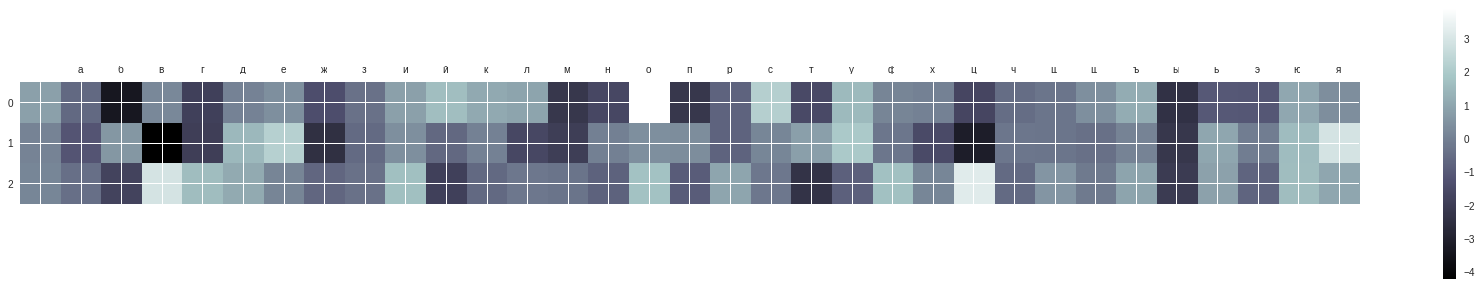

In [132]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

sim = np.zeros((3, len(russian_letters)))

for i in range(3):
  for j in range(len(russian_letters)):
    sim[i, j] = best_filter[i] @ embeddings[russian_letters_idx[j]]

fig = plt.figure(figsize=(30, 5))
ax = fig.add_subplot(111)
cax = ax.matshow(sim, cmap='bone')
fig.colorbar(cax)

ax.set_xticklabels([''] + russian_letters)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

## Attention and Convolutions

Напомню, что attention работает так: пусть у нас есть набор скрытых состояний $\mathbf{s}_1, \ldots, \mathbf{s}_m$ - например, представлений слов из исходного языка, полученных с помощью энкодера. И есть некоторое текущее скрытое состояние $\mathbf{h}_i$ - скажем, представление, используемое для предсказания слова на нужном нам языке.

Тогда с помощью аттеншена мы можем получить взвешенное представление контекста $\mathbf{s}_1, \ldots, \mathbf{s}_m$ - вектор $c_i$:
$$
\begin{align}\begin{split}
\mathbf{c}_i &= \sum\limits_j a_{ij}\mathbf{s}_j\\
\mathbf{a}_{ij} &= \text{softmax}(f_{att}(\mathbf{h}_i, \mathbf{s}_j))
\end{split}\end{align}
$$

$f_{att}$ - функция, которая говорит, насколько хорошо $\mathbf{h}_i$ и $\mathbf{s}_j$ подходят друг другу.

Самые популярные её варианты:
- Additive attention:
$$f_{att}(\mathbf{h}_i, \mathbf{s}_j) = \mathbf{v}_a{}^\top \text{tanh}(\mathbf{W}_a[\mathbf{h}_i; \mathbf{s}_j])$$
- Dot attention:
$$f_{att}(\mathbf{h}_i, \mathbf{s}_j) = \mathbf{h}_i^\top \mathbf{s}_j$$
- Multiplicative attention:
$$f_{att}(\mathbf{h}_i, \mathbf{s}_j) = \mathbf{h}_i^\top \mathbf{W}_a \mathbf{s}_j$$

Есть ещё одна вариация на тему - self-attention. Это когда у нас нет $\mathbf{h}_i$ - только $\mathbf{s}_j$-тые, т.е. вектора-представления исходной последовательности. Такое может очень естественно возникнуть практически в любой задаче - например, в классификации текстов.

Additive self-attention можно записать как $f_{att}(\mathbf{s}_i) = \mathbf{v}_a{}^\top \text{tanh}(\mathbf{W}_a \mathbf{s}_i)$. Тогда по последовательности $\mathbf{s}_1, \ldots, \mathbf{s}_m = \mathbf{S}$ вычисляется единственный вектор:
$$
\begin{align}\begin{split}
\mathbf{a} &= \text{softmax}(\mathbf{v}_a \text{tanh}(\mathbf{W}_a \mathbf{S}^\top))\\
\mathbf{c} & = \mathbf{S} \mathbf{a}^\top
\end{split}\end{align}
$$

При чём здесь были упомянуты свёртки? В основном при том, что они, вообще говоря, действуют похожим образом. 

Давайте посмотрим на операцию $\mathbf{v}_a \text{tanh}(\mathbf{W}_a \mathbf{S}^\top)$ как на извращенный вариант свертки с размером фильтра 1. Для каждого вектора $\mathbf{s_j}$ строится некоторая оценка того, насколько важно данное состояние.

Кроме того, кроме max-pooling'а существует ещё и avg-pooling - когда берется не максимальный сигнал, полученный сверткой, а средний. В какой-то степени $\mathbf{c} = \mathbf{S} \mathbf{a}^\top$ - тоже усреднение. Правда, усредняются исходные вектора, а не получающиеся оценки.

В таком self-attention мы выучиваем только один аналог фильтра сверточной сети. Но в сверточных сетях же много фильтров. Давайте тогда учить сразу несколько вариантов attention'а:
$$
\begin{align}\begin{split}
\mathbf{A} &= \text{softmax}(\mathbf{V}_a \text{tanh}(\mathbf{W}_a \mathbf{H}^\top))\\
\mathbf{C} & = \mathbf{A} \mathbf{H}
\end{split}\end{align}
$$

Утверждается, что случайной инициализации вполне достаточно, чтобы attention начал отлавливать разные характеристики из последовательности - такие лексическое и грамматическое значение слов. Но это и вполне естественно, если посмотреть, что свертки уже много лет так учат.

## Attention Is All You Need

В середине прошлого года вышла статья [Attention Is All You Need](https://arxiv.org/abs/1706.03762), которая опирается на эти идеи.

Она описывает Transformer - архитектуру полносвязной сети, которая делает то, что раньше все делали с помощью рекуррентных сетей. Хороший обзор был на хабре: [Transformer — новая архитектура нейросетей для работы с последовательностями](https://habrahabr.ru/post/341240/).

К задаче машинного перевода она применима так:  
![transformer](https://hsto.org/webt/59/f0/44/59f04410c0e56192990801.png =x600)

Из интересного - multi-head attention, который является аналогом того, что мы рассматривали в предыдущем разделе:  
![multi-head attn](https://hsto.org/webt/59/f0/44/59f0440f1109b864893781.png)

Сам attention выглядит так: 
$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{Q K^\top}{\sqrt{d_k}} \right) V,$$

Выглядит страшно, но в реальности передают в качестве $Q, K, V$ одну и ту же последовательность скрытых состояний - $\mathbf{S}$ из предыдущего раздела.

$Q K^\top$ - это как dot-attention.

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h) W^o$$ 
$$\text{head}_i = \text{Attention}(Q W^Q_i, K W^K_i, V W^V_i).$$

На pytorch это выглядит так (утащено из [attention-is-all-you-need-pytorch](https://github.com/jadore801120/attention-is-all-you-need-pytorch) и [seq2seq.pytorch](https://github.com/eladhoffer/seq2seq.pytorch)):

In [0]:
class ScaledDotProductAttention(nn.Module):
    """
    Scaled Dot-Product Attention
    """

    def __init__(self, dropout=0, causal=False):
        super(ScaledDotProductAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v):
        b_q, t_q, dim_q = q.size()
        b_k, t_k, dim_k = k.size()
        b_v, t_v, dim_v = v.size()
        qk = torch.bmm(q, k.transpose(1, 2))  # b x t_q x t_k
        qk.div_(dim_k ** 0.5)
        sm_qk = F.softmax(qk, dim=2)
        sm_qk = self.dropout(sm_qk)
        return torch.bmm(sm_qk, v), sm_qk  # b x t_q x dim_v


class MultiHeadAttention(nn.Module):
    """
    Scaled Dot-Product Attention
    """

    def __init__(self, input_size, output_size, num_heads, dropout=0):
        super(MultiHeadAttention, self).__init__()
        assert(input_size % num_heads == 0)
        self.input_size = input_size
        self.output_size = output_size
        self.num_heads = num_heads
        
        self.linear_q = nn.Linear(input_size, input_size)
        self.linear_k = nn.Linear(input_size, input_size)
        self.linear_v = nn.Linear(input_size, input_size)
        self.linear_out = nn.Linear(input_size, output_size)
        
        self.sdp_attention = ScaledDotProductAttention(dropout=dropout)

    def forward(self, q, k, v):
        b_q, t_q, dim_q = q.size()
        b_k, t_k, dim_k = k.size()
        b_v, t_v, dim_v = v.size()
        
        qw = self.linear_q(q)
        kw = self.linear_k(k)
        vw = self.linear_v(v)
        
        qw = qw.chunk(self.num_heads, 2)
        kw = kw.chunk(self.num_heads, 2)
        vw = vw.chunk(self.num_heads, 2)
        
        output = []
        attention_scores = []
        for i in range(self.num_heads):
            out_h, score = self.sdp_attention(qw[i], kw[i], vw[i])
            output.append(out_h)
            attention_scores.append(score)

        output = torch.cat(output, 2)

        return self.linear_out(output), attention_scores

Чтобы всё это заработало, нужно смотреть не только на эмбеддинги слов, но и на их позиции в тексте. Предлагается использовать позиционное кодирование вида:
$$\text{PE}_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})$$
$$\text{PE}_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})$$

Хотя можно и просто учить эмбеддинги.

Их можно предподсчитать:

In [0]:
def position_encoding_init(n_position, d_pos_vec):
    ''' Init the sinusoid position encoding table '''

    # keep dim 0 for padding token position encoding zero vector
    position_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_pos_vec) for j in range(d_pos_vec)]
        if pos != 0 else np.zeros(d_pos_vec) for pos in range(n_position)])

    position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2]) # dim 2i
    position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2]) # dim 2i+1
    return torch.from_numpy(position_enc).type(FloatTensor)

Энкодер выглядит просто:

In [0]:
class EncoderBlock(nn.Module):

    def __init__(self, hidden_size=512, num_heads=8, inner_linear=1024, layer_norm=True, dropout=0):

        super(EncoderBlock, self).__init__()
        if layer_norm:
            self.lnorm1 = LayerNorm1d(hidden_size)
            self.lnorm2 = LayerNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.attention = MultiHeadAttention(hidden_size, hidden_size, num_heads, dropout=dropout)
        self.fc = nn.Sequential(nn.Linear(hidden_size, inner_linear),
                                nn.ReLU(inplace=True),
                                nn.Dropout(dropout),
                                nn.Linear(inner_linear, hidden_size))

    def forward(self, x):
        res = x
        x, _ = self.attention(x, x, x)
        x = self.dropout(x).add_(res)
        x = self.lnorm1(x) if hasattr(self, 'lnorm1') else x
        res = x
        x = self.fc(x)
        x = self.dropout(x).add_(res)
        x = self.lnorm2(x) if hasattr(self, 'lnorm2') else x
        return x

Декодер отличается только необходимостью добавить маскинг - он должен смотреть только на предыдущие сгенерированные состояния, но не на следующие, и attention'ом на выход энкодера.